In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import trieste
import gpflow
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import math
from util import plotting

2021-11-29 09:10:41.354007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 09:10:41.354026: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-29 09:10:42.552339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 09:10:42.552683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 09:10:42.552729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [3]:
from trieste.objectives.multi_objectives import VLMOP2
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.data import Dataset
from trieste.models.gpflow.models import GPRStack
from trieste.models.gpflow.models import GaussianProcessRegression

from trieste.acquisition import BatchMonteCarloExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer

In [4]:
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point

In [5]:
search_space = trieste.space.Box([0], [2*math.pi])

def f1(x):
    return tf.cos(2 * x) + tf.sin(x)

def f2(x):
    return 0.2 * (tf.cos(x) - tf.sin(x)) + 0.3

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

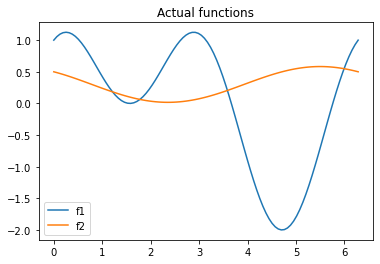

In [6]:
x_plot = np.linspace(start=search_space.lower[0], stop=search_space.upper[0], num=100)

plt.plot(x_plot, f1(x_plot), label="f1");
plt.plot(x_plot, f2(x_plot), label="f2");
plt.legend();
plt.title("Actual functions");
plt.show();

In [7]:
def build_stacked_independent_objectives_model(data: Dataset):
    gprs = []
    for idx in range(2):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return GPRStack(*gprs)

In [8]:
observer = mk_observer(f, OBJECTIVE)

In [9]:
initial_query_points = search_space.sample(10)
initial_data = observer(initial_query_points)

In [10]:
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

2021-11-29 09:10:42.956108: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
num_steps = 3
num_query_points=4

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

In [13]:
result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

2021-11-29 09:16:33.640547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-29 09:16:36.821865: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-29 09:16:40.460627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


Optimization completed without errors


In [14]:
models = result.try_get_final_models()[OBJECTIVE]._models

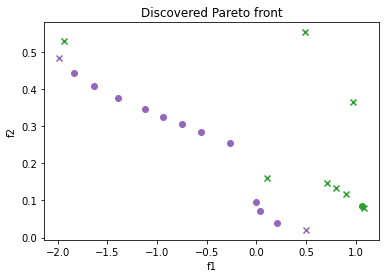

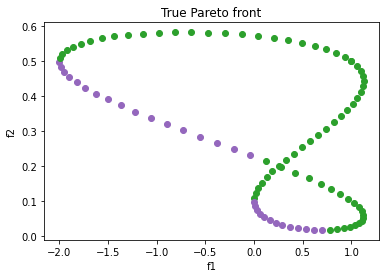

In [15]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=len(initial_query_points))
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

In [16]:
from trieste.acquisition.function.local_penalization import MOLocalPenalizationAcquisitionFunction

In [17]:
acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

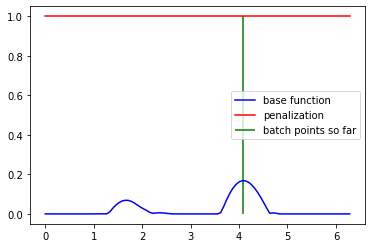

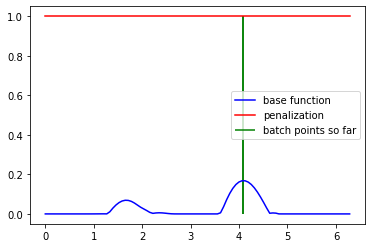

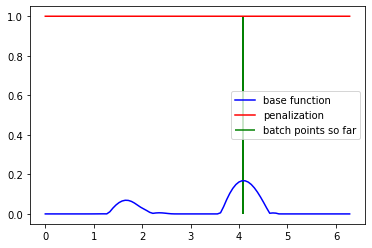

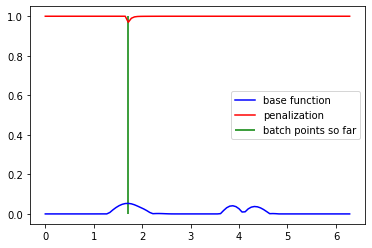

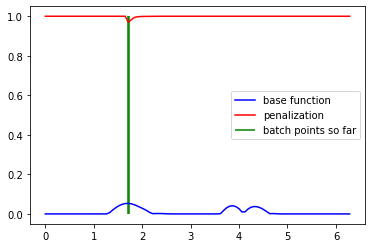

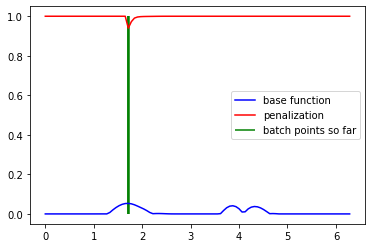

Optimization completed without errors


In [57]:
result = BayesianOptimizer(observer, search_space).optimize(2, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

In [ ]:
ref_point = get_reference_point(dataset.observations)

obs_hv = Pareto(dataset.observations).hypervolume_indicator(ref_point)
ideal_pf = tf.cast(VLMOP2().gen_pareto_optimal_points(100), dtype=tf.float64)
ideal_hv = Pareto(ideal_pf).hypervolume_indicator(ref_point)

print(tf.math.log(ideal_hv - obs_hv) < convergence_threshold)